In [1]:
import keras
import tensorflow as tf
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray
import numpy as np
import IDTreeS_dataset
from classification_models.keras import Classifiers

2023-09-01 12:35:22.306969: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 12:35:22.331061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Set Parameters for run:

In [18]:
# Data Parameters
train_test_split_size = 0.2
random_state = 0
shuffle = True

# Architecture Parameters
base_model_name ='ResNet18' #Options: ResNet18, ResNet50V2
activation = 'softmax'

# Compile options
metrics = ['accuracy']
optimizer = keras.optimizers.Adam()
loss_function = keras.losses.CategoricalCrossentropy(from_logits=False)

# Training Parameters
batch_size = 32
epochs = 50 

### Set Keras backend for image data format

In [3]:
keras.backend.set_image_data_format('channels_first')

### Load ResNet50V2 model from Keras and freeze weights

In [6]:
if base_model_name == 'ResNet50V2':
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling=None
    )
elif base_model_name == 'ResNet18':
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(input_shape=(3,100,100), weights='imagenet', include_top=False)
else:
    raise ValueError('Base model not defined')

In [7]:
base_model.trainable = False

In [9]:
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 3, 100, 100)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 3, 106, 106)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

### Load data and set model parameters

In [10]:
import glob

from rioxarray.exceptions import NoDataInBounds
from sklearn.preprocessing import LabelEncoder 

In [11]:
# Data Loader from IDTreeS Dataset
rgb_paths = glob.glob('./train/RemoteSensing/RGB/*.tif')
bboxes_paths = glob.glob('./train/ITC/train_*.shp')
classes_path = './train/Field/train_data.csv'

# Convert generator dataset in to suitable input for keras
ds = IDTreeS_dataset.IDTreeSDataset(rgb_paths, bboxes_paths, classes_path)

ids, Y, X = ds.get_cutouts()

nclasses = len(np.unique(Y)) #Number of classes in training data

In [19]:
def preprocess_data(X, Y, nclasses):
    if base_model_name == 'ResNet50V2':
        X_p = keras.applications.resnet_v2.preprocess_input(X)
    elif base_model_name == 'ResNet18':
        X_p = preprocess_input(X)
    else:
        raise ValueError('Model not defined')
    Y_p = keras.utils.to_categorical(Y, nclasses)
    return X_p, Y_p

X, Y = preprocess_data(X, Y, nclasses)

In [20]:
# Split train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=train_test_split_size, random_state=random_state, shuffle=shuffle)

### Create new model using the base model plus additional layers

In [21]:
def create_model():
    # Inputs
    inputs = keras.Input(shape=(3, 100, 100))

    # Run input image through our base model (ResNet)
    x = base_model(inputs, training = False)

    # Convert features from base model to a vector
    x = keras.layers.GlobalAveragePooling2D()(x)

    # # Create additional dense layers to fine tune the model
    # x = keras.layers.Dense(256)(x)
    # x = keras.layers.Dense(64)(x)

    # Create output layer
    outputs = keras.layers.Dense(nclasses, activation=activation)(x)

    return keras.Model(inputs, outputs)

model = create_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 model_1 (Functional)        (None, 512, 4, 4)         11186889  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 9)                 4617      
                                                                 
Total params: 11,191,506
Trainable params: 4,617
Non-trainable params: 11,186,889
_________________________________________________________________


In [22]:
# Compile the model
model.compile(optimizer=optimizer, 
              loss=loss_function,
              metrics=metrics)

In [23]:
# Train the model with preprocessed data
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 19s 1s/step - loss: 2.2271 - accuracy: 0.1432 - val_loss: 2.0516 - val_accuracy: 0.1942
Epoch 2/50
13/13 [==============================] - 21s 2s/step - loss: 2.0124 - accuracy: 0.2160 - val_loss: 2.0189 - val_accuracy: 0.2233
Epoch 3/50
13/13 [==============================] - 23s 2s/step - loss: 1.9481 - accuracy: 0.2597 - val_loss: 1.9850 - val_accuracy: 0.2718
Epoch 4/50
13/13 [==============================] - 25s 2s/step - loss: 1.8987 - accuracy: 0.3131 - val_loss: 1.9434 - val_accuracy: 0.3107
Epoch 5/50
13/13 [==============================] - 25s 2s/step - loss: 1.8547 - accuracy: 0.3471 - val_loss: 1.9150 - val_accuracy: 0.3010
Epoch 6/50
13/13 [==============================] - 25s 2s/step - loss: 1.8155 - accuracy: 0.3786 - val_loss: 1.8985 - val_accuracy: 0.3010
Epoch 7/50
13/13 [==============================] - 24s 2s/step - loss: 1.7863 - accuracy: 0.3883 - val_loss: 1.8672 - val_accuracy: 0.3592
Epoch 8/50
13/13 [==

In [24]:
# Predict on the train and test set
ypred_train = np.argmax(model.predict(X_train), axis=1)
ypred_val = np.argmax(model.predict(X_test), axis=1)

4/4 [==============================] - 5s 1s/step


In [25]:
import seaborn as sns
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

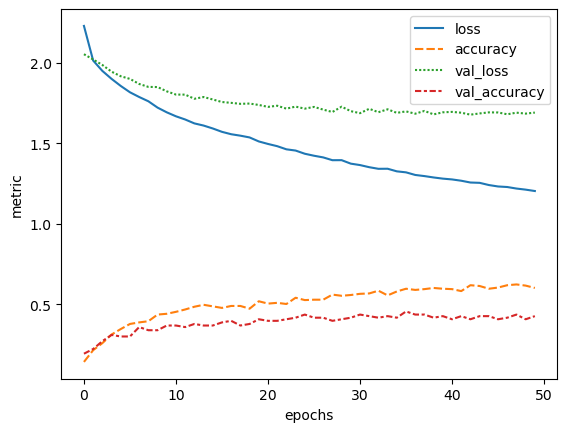

In [26]:
plot_history(history, ['loss', 'accuracy', 'val_loss', 'val_accuracy'] )

<Axes: >

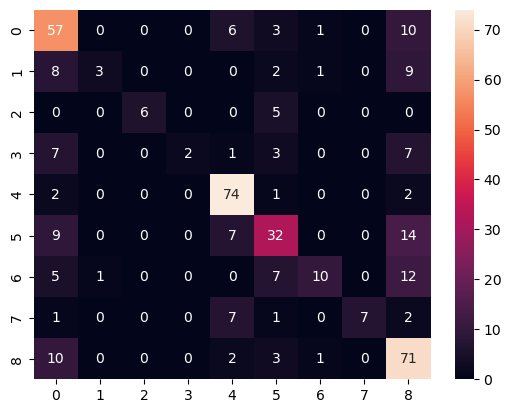

In [27]:
from sklearn.metrics import confusion_matrix

# Training data confusion matrix
true_train_label = np.argmax(y_train, axis=1)
matrix = confusion_matrix(true_train_label, ypred_train)
sns.heatmap(matrix, annot=True)

<Axes: >

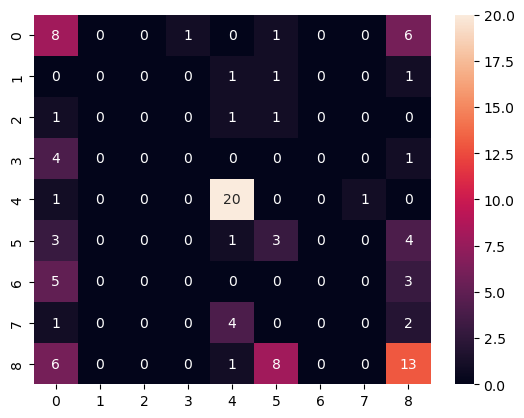

In [28]:
from sklearn.metrics import confusion_matrix

# Validation data confusion matrix
true_val_label = np.argmax(y_test, axis=1)
matrix = confusion_matrix(true_val_label, ypred_val)
sns.heatmap(matrix, annot=True)

In [29]:
import random 
print ('Correct predictions, Total samples, Accuracy')
print (np.count_nonzero(ypred_train - np.argmax(y_train, axis=1) == 0), y_train.shape[0], np.count_nonzero(ypred_train - np.argmax(y_train, axis=1) == 0)/y_train.shape[0])
print (np.count_nonzero(ypred_val - np.argmax(y_test, axis=1) == 0), y_test.shape[0], np.count_nonzero(ypred_val - np.argmax(y_test, axis=1) == 0)/y_test.shape[0])

Correct predictions, Total samples, Accuracy
262 412 0.6359223300970874
44 103 0.42718446601941745
